## Recurrent Neural Networks (RNN)

RNNs are type of Neural Networks that have their own internal memory. They work on the principle of saving the output of a particular layer and feeding this back to the input in order to predict the output of the layer.
They are widely used for speech recognition, voice recognition, time series prediction, and natural language processing. Because of their internal memory, RNNs can remember important things about the input they received, which allows them to be very precise in predicting what’s coming next. As a result, they can form a much deeper understanding of a sequence and its context compared to other algorithms.

<img src="RNN.png" width="400" />


In a RNN the information cycles through a loop. When it makes a decision, it considers the current input and also what it has learned from the inputs it received previously. RNNs apply weights to the current and also to the previous input. Furthermore, a recurrent neural network will also tweak the weights for both through gradient descent and backpropagation through time.


<img src="RNN3.png" width="600" />

from the above figure, where the formula for the current state $h_t = f(h_{t-1}, x_t)$, where $O_t$ is output state, $h_t$ current time stamp, $h_{t-1}$ is previous time stamp, and $x_t$ is passed as input state.


#### Issues with RNN training


The are two common problems with gradients (partial derivatives w.r.t inputs) during training with RNNs

- Exploding gradients: 
This happens when the algorithm assigns a unreasonably high importance to the weights. This can be solved by either truncating the backpropogation (start backprop with another timestamp instead of first), or by clipping the gradients to a threshold.

- Vanishing gradients:
This occurs when the values of a gradient are too small and the model stops learning or takes way too long as a result. It can be solved through the concept of LSTM networks.

Some resources for detailed RNN mathematics:

https://purnasaigudikandula.medium.com/recurrent-neural-networks-and-lstm-explained-7f51c7f6bbb9


### Long Short-Term Memory (LSTM)

Long short-term memory networks are an extension for recurrent neural networks, which basically extends the memory. Therefore it is well suited to learn from important experiences that have very long time lags in between. LSTMs have wide applications in time series forecasting, language modeling etc.
LSTMs have a three-step process in computations for each cell which can be achieved through 3 gates which are named as: Forget gate, Input gate, Output gate.

<img src="LSTM1.png" width="500" />

- Forget gate: This gate decides which information to be omitted in from the cell in that particular time stamp. It is decided by the sigmoid function. it looks at the previous state (ht-1) and the content input (Xt) and outputs a number between 0 and 1.
- Input gate: This gate analyzes the important information in the current input and has two functions: sigmoid decides which values to let through (0,1), and tanh gives weightage to the values which are passed deciding their level of importance ranging from -1 to 1.
- Output gate: This step decides what the output will be. It first runs a sigmoid layer, which decides what parts of the cell state make it to the output. Then, it puts the cell state through tanh to push the values to be between -1 and 1 and multiply it by the output of the forget gate.

https://builtin.com/data-science/recurrent-neural-networks-and-lstm

In [20]:
# !pip install torch==1.5.1 torchvision -f https://download.pytorch.org/whl/torch_stable.html
# !pip install d2l

In [21]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size, num_steps=20)

### Sentiment Analysis

With the proliferation of online social media and review platforms, a plethora of opinionated data have been logged, bearing great potential for supporting decision making processes. Sentiment analysis studies people’s sentiments in their produced text, such as product reviews, blog comments, and forum discussions. It enjoys wide applications to fields as diverse as politics (e.g., analysis of public sentiments towards policies), finance (e.g., analysis of sentiments of the market), and marketing (e.g., product research and brand management).

Since sentiments can be categorized as discrete polarities or scales (e.g., positive and negative), we can consider sentiment analysis as a text classification task, which transforms a varying-length text sequence into a fixed-length text category. We will use Stanford’s large movie review dataset for sentiment analysis. It consists of a training set and a testing set, either containing 25000 movie reviews downloaded from IMDb. In both datasets, there are equal number of “positive” and “negative” labels, indicating different sentiment polarities.


### Representing Single Text with RNNs

In text classifications tasks, such as sentiment analysis, a varying-length text sequence will be transformed into fixed-length categories. In the following BiRNN class, while each token of a text sequence gets its individual pretrained GloVe representation via the embedding layer (self.embedding), the entire sequence is encoded by a bidirectional RNN (self.encoder). More concretely, the hidden states (at the last layer) of the bidirectional LSTM at both the initial and final time steps are concatenated as the representation of the text sequence. This single text representation is then transformed into output categories by a fully-connected layer (self.decoder) with two outputs (“positive” and “negative”).

In [22]:
# print data

# each sentence has a 20 word limit

for id in train_iter.dataset.tensors[0][0].numpy():
    print(vocab.idx_to_token[id])
    
# print label - 0: negative, 1: positive
print(train_iter.dataset.tensors[1][0])

For
a
movie
that
gets
no
respect
there
sure
are
a
lot
of
memorable
quotes
listed
for
this
gem.
Imagine
tensor(1)


In [23]:
class RNN1(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(RNN1, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN

        self.encoder = nn.RNN(embed_size, num_hiddens, num_layers=num_layers,
                                 bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)
  

    def forward(self, inputs):

        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs


class LSTM1(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(LSTM1, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs

Specifying model architecture: 
- embed size: the number of features in the input layer
- num_hiddens: size of hiddern layers
- num_layers: number of layers
- activation function: tanh 

In [24]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
# net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net = RNN1(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

#### Loading Pretrained Word Vectors embeddings

Below we load the pretrained 100-dimensional (needs to be consistent with embed_size) GloVe embeddings for tokens in the vocabulary. We use these pretrained word vectors to represent tokens in the reviews.

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. https://nlp.stanford.edu/projects/glove/

In [25]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [26]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [27]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.612, train acc 0.650, test acc 0.613
2532.5 examples/sec on [device(type='cpu')]


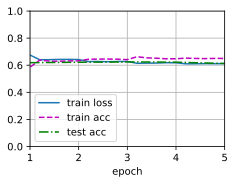

In [28]:
# training and evaluating RNN
# specify model config, loss, optimizer and train

lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.501, train acc 0.740, test acc 0.665
656.3 examples/sec on [device(type='cpu')]


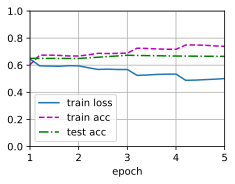

In [29]:
# training and evaluating LSTM
# specify model config, loss, optimizer and train
net = LSTM1(len(vocab), embed_size, num_hiddens, num_layers)
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [30]:
# function to predict sentiment for a given word

def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [31]:
predict_sentiment(net, vocab, 'this weather is so great')

'positive'

In [32]:
# misclassifications

import numpy as np
all_vocab = np.array(vocab.idx_to_token)

for ind, vec in enumerate(test_iter.dataset.tensors[0][:100].numpy()):
    w = ' '.join(all_vocab[vec])
    pred = predict_sentiment(net, vocab, w)
    
    if pred == 'positive' and test_iter.dataset.tensors[1][ind] == 0:
        print(w)
        print('\n')
    elif pred == 'negative' and test_iter.dataset.tensors[1][ind] == 1:
        print(w)
        print('\n')

The Italian Job requires daylight hours and no experience is required. This is a great matinee and a good afternoon


In the future, a disparate group of people asleep aboard a commercial spaceship is forced to improvise their survival when


<unk> <unk> is a show that you really have to be a certain age to appreciate. Otherwise, it's likely you'll


There were a lot of dumb teenage getting sex movies of the 80s and a lot of slasher flicks but


The original Female <unk> Scorpion is an all time masterpiece. The first sequel, <unk> <unk> was not quite as good


A film that tends to get buried under prejudice and <unk> - It's a <unk> Doris Day is in it!


A strange relationship between a middle-aged woman and a transsexual who gonna be a woman soon. Charlotte and <unk> both


i read the book before i saw the movie i knew the movie was going to be good because the


Watching John Cassavetes debut film is a strange experience, even if you've seen improvisational films before.<br /><br />Th